In [ ]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt
from scipy.special import softmax
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams.update({'font.size': 16})



In [ ]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [ ]:
#cd /export/usuarios_ml4ds/lbartolome/topicmodeler

In [ ]:
#from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
#from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
#from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [ ]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

In [ ]:
!git clone https://github.com/MIND-Lab/OCTIS.git

In [ ]:
cd OCTIS

In [ ]:
from octis.models.pytorchavitm.avitm import avitm_model as AVITM

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#from octis.models.pytorchavitm.datasets.bow import BOWDataset

import torch
from torch.utils.data import Dataset


class BOWDataset(Dataset):
    
    """Class to load BOW dataset."""

    def __init__(self, X, idx2token):

        """
        Initializes BOWDataset.

        Parameters
        ----------
        X : array-like, shape=(n_samples, n_features)
            Document-term matrix
        idx2token : list
            A list of feature names
        """
        self.X = X
        self.idx2token = idx2token

    def __len__(self):
        """Returns length of dataset."""
        return len(self.X)

    def __getitem__(self, i):
        """Returns sample from dataset at index i."""
        X = torch.FloatTensor(self.X[i])

        return {'X': X}

def prepare_dataset(corpus, val_size=0.25):
    """It prepares the training data in the format that is asked as input in AVITM.

    Parameters
    ----------
    corpus: List[str]
        List of documents to be used for training of the model
    val_size: float (default=0.25)
        Percentage of the documents to be used for validation

    Returns
    -------
    train_data: BOWDataset
        Training dataset in the required format for AVITM
    val_data: BOWDataset
        Validation dataset in the required format for AVITM
    input_size: int
        Size of the input dimensions of the AVITM model to be trained
    id2token: tuple
        Mappings with the content of each training dataset's document-term matrix.

    """

    # Divide data into training and validation
    docs_train, docs_val = train_test_split(corpus, test_size=val_size, random_state=42)

    # Create a CountVectorizer object to convert a collection of text documents into a matrix of token counts
    # Max and min_df not considered since cleaning is being previously performed
    cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)

    #########################################
    # Prepare train dataset in AVITM format #
    #########################################
    docs_train_conv = [" ".join(docs_train[i]) for i in np.arange(len(docs_train))]

    # Learn the vocabulary dictionary, train_bow = document-term matrix.
    train_bow = cv.fit_transform(docs_train_conv).toarray()

    # Array mapping from feature integer indices to feature name.
    idx2token = cv.get_feature_names_out()
    input_size = len(idx2token)
    id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}

    # The train dataset is an object from the class BOWDataset
    train_data = BOWDataset(train_bow, idx2token)

    ##############################################
    # Prepare validation dataset in AVITM format #
    ##############################################
    docs_val_conv = [" ".join(docs_val[i]) for i in np.arange(len(docs_val))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    return train_data, val_data, input_size, id2token, docs_train, cv

## **1. Creation of synthetic corpus functions**


---

In [ ]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [ ]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [ ]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [ ]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_mat()#get_topic_word_distribution()
        wd = softmax(betas, axis=1)
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [ ]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    #avitm = AVITM(logger=None,
    #          input_size=input_size,
    #          n_components=n_topics,
    #          model_type="prodLDA",
    #          hidden_sizes=(100, 100),
    #          activation='softplus',
    #          dropout=0.2,
    #          learn_priors=True,
    #          batch_size=64,
    #          lr=2e-3,
    #          momentum=0.99,
    #          solver='adam',
    #          num_epochs=100,
    #          reduce_on_plateau=False,
    #          topic_prior_mean=0.0,
    #          topic_prior_variance=None,
    #          num_samples=20,
    #          num_data_loader_workers=0,
    #          verbose=True)
    
    avitm = AVITM.AVITM_model(input_size=input_size,
                  num_topics=n_topics,
                  model_type='prodLDA',
                  hidden_sizes=(100, 100),
                  activation='softplus',
                  dropout=0.2,
                  learn_priors=True,
                  batch_size=64,
                  lr=2e-3,
                  momentum=0.99,
                  solver='adam',
                  num_epochs=100,
                  reduce_on_plateau=False,
                  topic_prior_mean=0.0,
                  topic_prior_variance=None,
                  num_samples=10,
                  num_data_loader_workers=0,
                  verbose=False)
    
    
    
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [ ]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [ ]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [ ]:
n_nodes = 5

In [ ]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 1e-2
alpha = 5/n_topics
n_docs = 10
n_docs_inf = 10
n_docs_global_inf = 10#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [ ]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [38]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_thetas_baseline = []
sim_betas_bas = []
for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Baseline doc-topics generation
    topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_bas = doc_topics_all[i]
        else:
            thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
    print("Shape of thetas_bas", str(thetas_bas.shape))
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    print(topic_vectors.shape)
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    #Here we compare alignment of the topic_vector matrix with itself and with another randomly generated matrix
    eta = tm_settings["beta"]
    topic_vectors2 = np.random.dirichlet(vocab_size*[eta], n_topics)
    betas_bas = eval_betas(topic_vectors2, topic_vectors)
    sim_betas_bas.append(betas_bas)
    
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    print("MAX BETAS: ", np.max(betas))
    print("MIN BETAS: ", np.min(betas))
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)
    
    ########################
    #       Baseline       #
    ########################
    print("BASELINE")
    thetas_theoretical = inf_doc_topics
    thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
    sim_thetas_baseline.append(thetas_baseline)

Executing for frozen topics  5
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 32.07it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 32.18it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 32.06it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.32it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 32.00it/s]


(50, 5000)
Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
39.656991994694394
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1813.4244	Time: 0:00:00.523510
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1699.349165625	Time: 0:00:00.079079
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1804.40463125	Time: 0:00:00.473919
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1712.82304375	Time: 0:00:00.060610
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1797.5874	Time: 0:00:00.478591
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1711.430146875	Time: 0:00:00.078193
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1790.55661875	Time: 0:00:00.470150
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 17

Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1801.0867708333333	Time: 0:00:00.105717
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1716.30846875	Time: 0:00:00.016063
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1799.4869791666667	Time: 0:00:00.104001
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1720.7913125	Time: 0:00:00.016152
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1792.6252708333334	Time: 0:00:00.106719
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1725.37453125	Time: 0:00:00.016344
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1788.52490625	Time: 0:00:00.105174
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1726.30878125	Time: 0:00:00.016052
Early stopping
Tópicos (equivalentes) evaluados correctamente:
44.312503984798674
Difference in evaluation of doc similarity:
4075.2563841313295
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/pro

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.34it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.65it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.67it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.50it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.54it/s]


(50, 5000)
Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
39.66411878798159
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1813.9035979166667	Time: 0:00:00.517106
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1699.567690625	Time: 0:00:00.079932
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1803.41309375	Time: 0:00:00.512274
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1713.717325	Time: 0:00:00.078781
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1795.4155979166667	Time: 0:00:00.513790
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1714.808915625	Time: 0:00:00.079799
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1789.1415291666667	Time: 0:00:00.514111
Epoch: [4/100]	Samples: [1250/125000]

Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1801.15315625	Time: 0:00:00.105084
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1736.85453125	Time: 0:00:00.016515
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1796.1812604166666	Time: 0:00:00.105464
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1740.04021875	Time: 0:00:00.016103
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1794.9539270833334	Time: 0:00:00.107084
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1744.90015625	Time: 0:00:00.016152
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1789.0579375	Time: 0:00:00.104850
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1748.9879375	Time: 0:00:00.015982
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1787.0967708333333	Time: 0:00:00.104990
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1751.09840625	Time: 0:00:00.016225
Early stopping
Tópicos (equivalentes) evaluados correctamente:
44.316006655274535
Difference in evaluation of doc similarity:
3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.53it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.52it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:03<00:00, 31.63it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.63it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.96it/s]


(50, 5000)
Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
39.682968933294916
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1810.6351166666666	Time: 0:00:00.492711
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1707.96411875	Time: 0:00:00.079340
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1800.7533375	Time: 0:00:00.518897
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1723.1083375	Time: 0:00:00.079306
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1792.004125	Time: 0:00:00.525091
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1721.4223625	Time: 0:00:00.066946
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1784.9912020833333	Time: 0:00:00.519856
Epoch: [4/100]	Samples: [1250/125000]	Validati

Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1794.9415208333332	Time: 0:00:00.108338
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1731.0449375	Time: 0:00:00.014221
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1795.0396979166667	Time: 0:00:00.106331
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1736.33309375	Time: 0:00:00.016824
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1787.8243229166667	Time: 0:00:00.107715
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1740.59815625	Time: 0:00:00.017413
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1784.7817916666668	Time: 0:00:00.110187
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1743.69934375	Time: 0:00:00.016824
Early stopping
Tópicos (equivalentes) evaluados correctamente:
44.3115565855377
Difference in evaluation of doc similarity:
3760.072750235754
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/p

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.06it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.02it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.14it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 33.98it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.23it/s]


(50, 5000)
Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
Tópicos (equivalentes) evaluados correctamente:
39.65074249241734
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1806.3143833333334	Time: 0:00:00.540315
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1690.804759375	Time: 0:00:00.080774
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1796.84844375	Time: 0:00:00.536587
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1704.16614375	Time: 0:00:00.079863
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1789.0992291666666	Time: 0:00:00.532628
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1705.11828125	Time: 0:00:00.080643
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1782.5324270833332	Time: 0:00:00.531034
Epoch: [4/100]	Samples: [1250/125000

Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1789.68115625	Time: 0:00:00.104537
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1689.7605	Time: 0:00:00.015857
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1788.3625416666666	Time: 0:00:00.109827
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1693.255875	Time: 0:00:00.018513
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1780.3643020833333	Time: 0:00:00.122654
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1697.73496875	Time: 0:00:00.018702
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1777.9501666666667	Time: 0:00:00.121777
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1702.51665625	Time: 0:00:00.018549
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1776.6466979166667	Time: 0:00:00.121453
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1703.32971875	Time: 0:00:00.018900
Early stopping
Tópicos (equivalentes) evaluados correctamente:
44.327371155837824
Difference in evaluation of doc similarity:


In [22]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[8.475764244836515, 8.572908513959375, 8.406221604272154, 8.448220505647944]
[6.3482254583470015, 6.884024631684565, 7.049580128780813, 7.954827175079664]


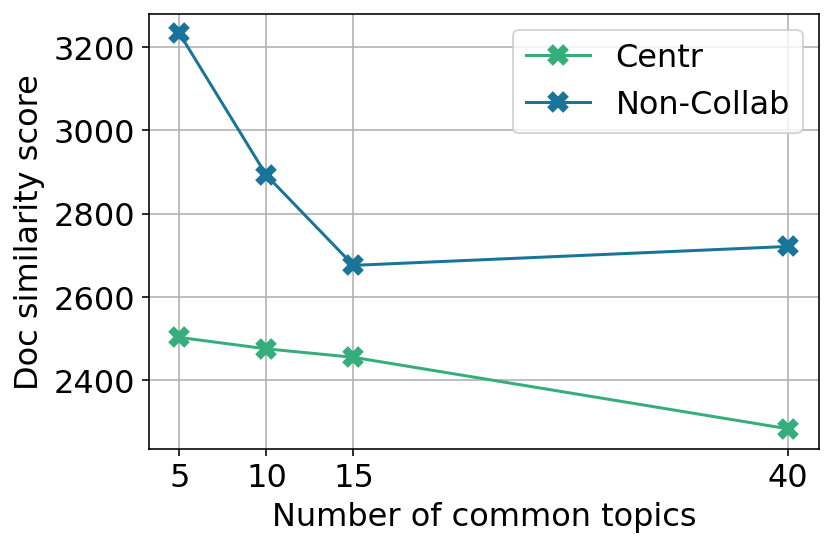

In [23]:
#plt.rcParams['figure.figsize'] = [8, 6]
#color = "#36AE7C"
#color = "#187498"
plt.plot(frozen_topics_list, sim_thetas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.plot(frozen_topics_list, sim_thetas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
#plt.plot(frozen_topics_list, sim_thetas_baseline, label="Baseline")
plt.legend(loc="best")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
#plt.tick_params(axis='x', which='minor')

#plt.locator_params(axis="x",bins=3)
plt.grid()
plt.show()

In [24]:
#fig, ax = plt.subplots()
#ax.semilogx(x, y)
# plt.locator_params(axis="x", nbins=3)
# ax.locator_params(tight=True, nbins=4)
#xticks = ax.get_xticks()
# ax.set_xticks(xticks[::len(xticks) // 2]) # set new tick positions
#ax.set_xticks([1.e-04, 1.e-01, 1.e+00, 6.e+00])
# ax.tick_params(axis='x', rotation=30) # set tick rotation
#ax.margins(x=0) # set tight margins

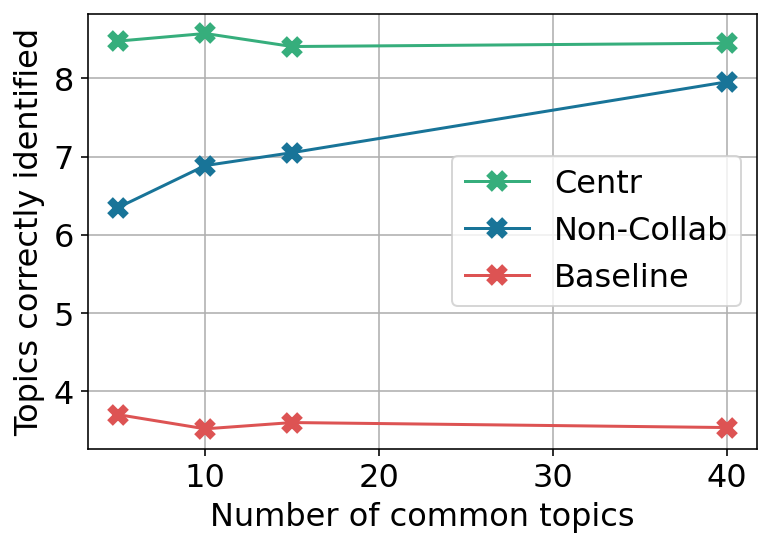

In [25]:
plt.plot(frozen_topics_list, sim_betas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.plot(frozen_topics_list, sim_betas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
plt.plot(frozen_topics_list, sim_betas_bas, label="Baseline", marker="x", markersize=8, mew=4, color = "#DD5353")
plt.legend(loc="best")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Topics correctly identified', fontsize=16)
#plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()

In [33]:
frozen_topics_list = [5,10,15,40]
eta_list = [1e-2, 0.02, 0.03, 0.04, 0.08, 1]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_betas_bas = []

for eta in eta_list:
    print("Executing for eta equals to ", str(eta))
    
    tm_settings["beta"] = eta
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics_list[1] * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    # Generate a randomly generate topic vector matrix to compare the alignment with the true one
    
    #Here we compare alignment of the topic_vector matrix with itself and with another randomly generated matrix
    topic_vectors2 = np.random.dirichlet(vocab_size*[eta], n_topics)
    betas_bas = eval_betas(topic_vectors2, topic_vectors)
    sim_betas_bas.append(betas_bas)
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)

Executing for eta equals to  0.01
Generating document words for node  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.32it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.80it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:51<00:00, 38.96it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.34it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.09it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
3.6883111076696244
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1662.0141458333333	Time: 0:00:00.495290
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1619.387715625	Time: 0:00:00.074859
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1547.324003125	Time: 0:00:00.486136
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1488.918896875	Time: 0:00:00.086766
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1506.124365625	Time: 0:00:00.666180
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1459.27515625	Time: 0:00:00.072543
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1486.1989125	Time: 0:00:00.481667
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss:

Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1450.1295885416666	Time: 0:00:00.086552
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1409.4949375	Time: 0:00:00.012483
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1433.9496875	Time: 0:00:00.085950
Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1404.40965625	Time: 0:00:00.013012
Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1429.7377291666667	Time: 0:00:00.087256
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1394.90753125	Time: 0:00:00.012345
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1420.5896197916666	Time: 0:00:00.087230
Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1395.11809375	Time: 0:00:00.012447
Epoch: [13/100]	Samples: [9750/75000]	Train Loss: 1416.4989114583334	Time: 0:00:00.089556
Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1389.27409375	Time: 0:00:00.012289
Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1408.2409270833334	Time: 0:00:00.088865
Epoch: [14/100]	Samples

Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1408.5530364583333	Time: 0:00:00.086164
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1364.1708125	Time: 0:00:00.012259
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1411.6215208333333	Time: 0:00:00.089788
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1355.88296875	Time: 0:00:00.012138
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1407.057125	Time: 0:00:00.089321
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1356.61228125	Time: 0:00:00.012577
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1408.7170520833333	Time: 0:00:00.087241
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1357.7765625	Time: 0:00:00.012128
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1402.8082708333334	Time: 0:00:00.086383
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1349.98515625	Time: 0:00:00.012766
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1397.6355833333334	Time: 0:00:00.086209
Epoch: [24/100]	Sa

Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1416.8019895833334	Time: 0:00:00.088926
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1362.3840625	Time: 0:00:00.012339
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1413.8014114583334	Time: 0:00:00.087542
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1358.6223125	Time: 0:00:00.012208
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1410.574203125	Time: 0:00:00.087563
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1354.45753125	Time: 0:00:00.012577
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1409.7853645833334	Time: 0:00:00.089996
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1349.6610625	Time: 0:00:00.014805
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1403.8816458333333	Time: 0:00:00.087682
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1349.89684375	Time: 0:00:00.012725
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1404.307671875	Time: 0:00:00.086706
Epoch: [24/100]	Samp

Epoch: [37/100]	Samples: [27750/75000]	Train Loss: 1371.3888958333334	Time: 0:00:00.088749
Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1373.0075625	Time: 0:00:00.015158
Epoch: [38/100]	Samples: [28500/75000]	Train Loss: 1370.4219479166666	Time: 0:00:00.085197
Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1378.6504375	Time: 0:00:00.014778
Epoch: [39/100]	Samples: [29250/75000]	Train Loss: 1370.2920520833334	Time: 0:00:00.084300
Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1371.29121875	Time: 0:00:00.013531
Epoch: [40/100]	Samples: [30000/75000]	Train Loss: 1373.294359375	Time: 0:00:00.088839
Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1375.75490625	Time: 0:00:00.014621
Epoch: [41/100]	Samples: [30750/75000]	Train Loss: 1375.5590989583334	Time: 0:00:00.117262
Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1373.24503125	Time: 0:00:00.018286
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1369.4989791666667	Time: 0:00:00.122329
Epoch: [42/100]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.52it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.74it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.81it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.63it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.23it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
4.797003996310602
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1730.128040625	Time: 0:00:00.518339
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1663.346353125	Time: 0:00:00.073909
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1619.0947125	Time: 0:00:00.504131
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1554.256175	Time: 0:00:00.059564
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1576.3264604166666	Time: 0:00:00.442187
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1528.831225	Time: 0:00:00.059093
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1555.9044979166667	Time: 0:00:00.436824
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1

Epoch: [45/100]	Samples: [168750/375000]	Train Loss: 1474.9935166666667	Time: 0:00:00.441139
Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1447.974209375	Time: 0:00:00.061217
Epoch: [46/100]	Samples: [172500/375000]	Train Loss: 1473.518890625	Time: 0:00:00.435447
Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1453.41135	Time: 0:00:00.061747
Epoch: [47/100]	Samples: [176250/375000]	Train Loss: 1474.3394854166668	Time: 0:00:00.449264
Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1443.4748	Time: 0:00:00.061489
Epoch: [48/100]	Samples: [180000/375000]	Train Loss: 1472.269996875	Time: 0:00:00.445145
Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1441.19235	Time: 0:00:00.062788
Early stopping
Tópicos (equivalentes) evaluados correctamente:
11.492452169734557
Difference in evaluation of doc similarity:
2131.3826529761473
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lb

Tópicos (equivalentes) evaluados correctamente:
10.060215279264707
Difference in evaluation of doc similarity:
2211.9604345171338
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [750/75000]	Train Loss: 1731.0131145833334	Time: 0:00:00.086633
Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1611.1196875	Time: 0:00:00.015497
Epoch: [2/100]	Samples: [1500/75000]	Train Loss: 1703.9115	Time: 0:00:00.086968
Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1621.1309375	Time: 0:00:00.012242
Epoch: [3/100]	Samples: [2250/75000]	Train Loss: 1661.61909375	Time: 0:00:00.089812
Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1628.742	Time: 0:00:00.012599
Epoch: [4/100]	Samples: [3000/75000]	Train Loss: 1626.5696458333334	Time: 0:00:00.099422
Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1616.9696875	

Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1611.181375	Time: 0:00:00.100081
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1613.251	Time: 0:00:00.015087
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1588.8806979166666	Time: 0:00:00.099780
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1569.34909375	Time: 0:00:00.014963
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1569.98203125	Time: 0:00:00.100187
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1538.482	Time: 0:00:00.014880
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1557.8457291666666	Time: 0:00:00.099605
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1519.1533125	Time: 0:00:00.014890
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1548.15046875	Time: 0:00:00.100087
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1502.56884375	Time: 0:00:00.015206
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1535.3016979166666	Time: 0:00:00.099778
Epoch: [10/100]	Samples: [250/25000]	Validation Loss:

Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1565.84028125	Time: 0:00:00.098253
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1546.8429375	Time: 0:00:00.015065
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1545.3370833333333	Time: 0:00:00.098774
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1524.78996875	Time: 0:00:00.014848
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1531.2003333333334	Time: 0:00:00.097290
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1521.33503125	Time: 0:00:00.015159
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1528.7513020833333	Time: 0:00:00.098374
Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1511.36659375	Time: 0:00:00.014746
Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1515.52203125	Time: 0:00:00.099010
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1501.5175	Time: 0:00:00.014967
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1512.8824583333333	Time: 0:00:00.098538
Epoch: [12/100]	Samples: [250/25000]

Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1568.3554895833333	Time: 0:00:00.098348
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1522.2433125	Time: 0:00:00.014925
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1547.2150208333333	Time: 0:00:00.098803
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1506.92140625	Time: 0:00:00.014695
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1534.43984375	Time: 0:00:00.099147
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1496.516375	Time: 0:00:00.015042
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1526.3078541666666	Time: 0:00:00.098978
Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1486.9238125	Time: 0:00:00.014444
Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1524.1497291666667	Time: 0:00:00.099049
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1479.472	Time: 0:00:00.014806
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1511.3658020833334	Time: 0:00:00.098133
Epoch: [12/100]	Samples: [250/25000

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.69it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 35.04it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.53it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.33it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.16it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
5.9640495014770005
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1753.6500239583333	Time: 0:00:00.516943
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1684.05615625	Time: 0:00:00.079752
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1651.18329375	Time: 0:00:00.512503
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1594.1717875	Time: 0:00:00.080704
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1610.0932291666666	Time: 0:00:00.511873
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1566.264909375	Time: 0:00:00.080312
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1589.8934333333334	Time: 0:00:00.510846
Epoch: [4/100]	Samples: [1250/125000]	Validatio

Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1556.43109375	Time: 0:00:00.101469
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1541.1891875	Time: 0:00:00.015410
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1548.3961666666667	Time: 0:00:00.100779
Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1532.9465	Time: 0:00:00.015490
Epoch: [13/100]	Samples: [9750/75000]	Train Loss: 1551.8586770833333	Time: 0:00:00.100394
Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1530.16096875	Time: 0:00:00.015409
Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1537.8684895833333	Time: 0:00:00.100898
Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1527.3790625	Time: 0:00:00.017107
Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1536.023	Time: 0:00:00.098824
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1524.4485	Time: 0:00:00.015447
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1534.904125	Time: 0:00:00.101810
Epoch: [16/100]	Samples: [250/25000]	Validat

Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1561.8229166666667	Time: 0:00:00.100094
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1529.35975	Time: 0:00:00.015071
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1561.8657291666666	Time: 0:00:00.100069
Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1521.54765625	Time: 0:00:00.015262
Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1555.5846041666666	Time: 0:00:00.101815
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1517.72415625	Time: 0:00:00.015696
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1552.3499583333332	Time: 0:00:00.100267
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1514.999	Time: 0:00:00.015356
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1544.84065625	Time: 0:00:00.100776
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1519.11065625	Time: 0:00:00.015416
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1548.2672083333334	Time: 0:00:00.099338
Epoch: [20/100]	Sample

Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1542.9278958333334	Time: 0:00:00.117753
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1496.66525	Time: 0:00:00.018212
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1536.2233958333334	Time: 0:00:00.117756
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1496.83428125	Time: 0:00:00.018376
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1530.73015625	Time: 0:00:00.117518
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1495.3985625	Time: 0:00:00.018514
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1531.2361875	Time: 0:00:00.117698
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1492.1531875	Time: 0:00:00.018488
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1523.7693958333334	Time: 0:00:00.117559
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1491.9533125	Time: 0:00:00.018285
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1523.7472604166667	Time: 0:00:00.118521
Epoch: [22/100]	Samples: [

Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1510.2109375	Time: 0:00:00.100210
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1504.64515625	Time: 0:00:00.014979
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1507.94378125	Time: 0:00:00.099914
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1509.25175	Time: 0:00:00.016769
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1508.9376145833332	Time: 0:00:00.101488
Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1502.6229375	Time: 0:00:00.015189
Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1507.501875	Time: 0:00:00.099966
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1501.84290625	Time: 0:00:00.014943
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1506.7425104166666	Time: 0:00:00.100233
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1501.8276875	Time: 0:00:00.015322
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1502.2819583333333	Time: 0:00:00.099781
Epoch: [27/100]	Samples: [250/25

Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1505.4744375	Time: 0:00:00.100697
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1496.8121875	Time: 0:00:00.015549
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1507.1467395833333	Time: 0:00:00.100668
Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1493.412875	Time: 0:00:00.015453
Epoch: [33/100]	Samples: [24750/75000]	Train Loss: 1500.5681770833332	Time: 0:00:00.100044
Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1492.94384375	Time: 0:00:00.015468
Epoch: [34/100]	Samples: [25500/75000]	Train Loss: 1504.2589791666667	Time: 0:00:00.099495
Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1490.3836875	Time: 0:00:00.015591
Epoch: [35/100]	Samples: [26250/75000]	Train Loss: 1500.8551041666667	Time: 0:00:00.099223
Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1491.686375	Time: 0:00:00.015462
Epoch: [36/100]	Samples: [27000/75000]	Train Loss: 1496.4871770833333	Time: 0:00:00.098982
Epoch: [36/100]	Sampl

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.49it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.26it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.57it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.48it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.35it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
7.108378678129911
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1763.2522479166666	Time: 0:00:00.521360
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1689.9421375	Time: 0:00:00.079514
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1668.205678125	Time: 0:00:00.694970
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1604.72994375	Time: 0:00:00.080645
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1624.9162197916667	Time: 0:00:00.509413
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1579.589728125	Time: 0:00:00.078698
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1606.2443677083334	Time: 0:00:00.508454
Epoch: [4/100]	Samples: [1250/125000]	Validatio

Epoch: [45/100]	Samples: [168750/375000]	Train Loss: 1531.3750697916666	Time: 0:00:00.528442
Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1501.1381125	Time: 0:00:00.081196
Epoch: [46/100]	Samples: [172500/375000]	Train Loss: 1532.2234385416666	Time: 0:00:00.521470
Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1501.588853125	Time: 0:00:00.065613
Epoch: [47/100]	Samples: [176250/375000]	Train Loss: 1531.657959375	Time: 0:00:00.498145
Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1502.551271875	Time: 0:00:00.081163
Early stopping
Tópicos (equivalentes) evaluados correctamente:
16.65925228671235
Difference in evaluation of doc similarity:
2175.236554692141
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [750/75000]	Train Loss: 1773.6491979166667	Time: 0:00:00.092054
Epoch: [1/100]

Epoch: [43/100]	Samples: [32250/75000]	Train Loss: 1518.6395208333333	Time: 0:00:00.104148
Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1511.31540625	Time: 0:00:00.015828
Epoch: [44/100]	Samples: [33000/75000]	Train Loss: 1518.1498854166666	Time: 0:00:00.104818
Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1513.20075	Time: 0:00:00.015852
Epoch: [45/100]	Samples: [33750/75000]	Train Loss: 1517.6278020833333	Time: 0:00:00.105108
Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1511.34496875	Time: 0:00:00.015979
Epoch: [46/100]	Samples: [34500/75000]	Train Loss: 1512.7331145833334	Time: 0:00:00.105389
Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1512.10371875	Time: 0:00:00.015804
Epoch: [47/100]	Samples: [35250/75000]	Train Loss: 1512.4133333333334	Time: 0:00:00.104993
Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1510.20621875	Time: 0:00:00.015866
Epoch: [48/100]	Samples: [36000/75000]	Train Loss: 1514.7620208333333	Time: 0:00:00.104018
Epoch: [48/1

Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1543.0439166666667	Time: 0:00:00.104155
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1533.06521875	Time: 0:00:00.015759
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1544.39628125	Time: 0:00:00.104660
Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1532.7695625	Time: 0:00:00.015864
Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1544.5250625	Time: 0:00:00.104473
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1533.52075	Time: 0:00:00.016081
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1543.5495833333334	Time: 0:00:00.104449
Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1528.6495	Time: 0:00:00.015768
Epoch: [33/100]	Samples: [24750/75000]	Train Loss: 1541.2755104166667	Time: 0:00:00.104887
Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1528.143125	Time: 0:00:00.015743
Epoch: [34/100]	Samples: [25500/75000]	Train Loss: 1538.1222708333332	Time: 0:00:00.104894
Epoch: [34/100]	Samples: [250/

Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1536.4355729166666	Time: 0:00:00.106378
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1539.52715625	Time: 0:00:00.015757
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1534.4401666666668	Time: 0:00:00.102722
Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1541.94103125	Time: 0:00:00.015586
Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1534.7336145833333	Time: 0:00:00.105008
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1539.33278125	Time: 0:00:00.015789
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1528.75765625	Time: 0:00:00.103684
Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1538.55853125	Time: 0:00:00.015343
Early stopping
Tópicos (equivalentes) evaluados correctamente:
15.656114234680865
Difference in evaluation of doc similarity:
2162.383582778276
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartol

Epoch: [43/100]	Samples: [32250/75000]	Train Loss: 1524.2199791666667	Time: 0:00:00.105770
Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1528.4805	Time: 0:00:00.015978
Epoch: [44/100]	Samples: [33000/75000]	Train Loss: 1525.8266145833334	Time: 0:00:00.104835
Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1524.80315625	Time: 0:00:00.016031
Epoch: [45/100]	Samples: [33750/75000]	Train Loss: 1526.5008541666666	Time: 0:00:00.105256
Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1528.9043125	Time: 0:00:00.015991
Epoch: [46/100]	Samples: [34500/75000]	Train Loss: 1525.17884375	Time: 0:00:00.104680
Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1527.27325	Time: 0:00:00.015634
Epoch: [47/100]	Samples: [35250/75000]	Train Loss: 1524.3861041666667	Time: 0:00:00.107476
Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1527.44071875	Time: 0:00:00.016153
Epoch: [48/100]	Samples: [36000/75000]	Train Loss: 1525.6574375	Time: 0:00:00.105094
Epoch: [48/100]	Samples: [25

Epoch: [39/100]	Samples: [29250/75000]	Train Loss: 1513.27021875	Time: 0:00:00.101124
Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1510.817875	Time: 0:00:00.015532
Epoch: [40/100]	Samples: [30000/75000]	Train Loss: 1514.7385104166667	Time: 0:00:00.101764
Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1510.7056875	Time: 0:00:00.015282
Epoch: [41/100]	Samples: [30750/75000]	Train Loss: 1511.23575	Time: 0:00:00.101862
Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1512.88959375	Time: 0:00:00.015576
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1514.2713958333334	Time: 0:00:00.102394
Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1513.961	Time: 0:00:00.015454
Epoch: [43/100]	Samples: [32250/75000]	Train Loss: 1513.5566041666666	Time: 0:00:00.104336
Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1513.59596875	Time: 0:00:00.015737
Epoch: [44/100]	Samples: [33000/75000]	Train Loss: 1515.99646875	Time: 0:00:00.102789
Epoch: [44/100]	Samples: [250/25000

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.61it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.86it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.62it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.81it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.49it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
11.570382395943126
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1798.0211729166667	Time: 0:00:00.525594
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1712.281734375	Time: 0:00:00.080260
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1726.5319854166667	Time: 0:00:00.519391
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1675.94728125	Time: 0:00:00.069398
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1680.599478125	Time: 0:00:00.520626
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1645.52380625	Time: 0:00:00.072165
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1655.088290625	Time: 0:00:00.510872
Epoch: [4/100]	Samples: [1250/125000]	Validation 

Epoch: [45/100]	Samples: [168750/375000]	Train Loss: 1581.1982052083333	Time: 0:00:00.517079
Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1573.380928125	Time: 0:00:00.080919
Epoch: [46/100]	Samples: [172500/375000]	Train Loss: 1582.4396447916668	Time: 0:00:00.511166
Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1571.07215625	Time: 0:00:00.082545
Epoch: [47/100]	Samples: [176250/375000]	Train Loss: 1581.293065625	Time: 0:00:00.523156
Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1569.689734375	Time: 0:00:00.082374
Epoch: [48/100]	Samples: [180000/375000]	Train Loss: 1579.9838833333333	Time: 0:00:00.522351
Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1571.602878125	Time: 0:00:00.082994
Epoch: [49/100]	Samples: [183750/375000]	Train Loss: 1579.6486104166668	Time: 0:00:00.518958
Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1573.2473125	Time: 0:00:00.081512
Epoch: [50/100]	Samples: [187500/375000]	Train Loss: 1580.945653125	Time: 0:00:00.

Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1608.3901875	Time: 0:00:00.106879
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1613.5349375	Time: 0:00:00.016003
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1605.5456145833334	Time: 0:00:00.106302
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1613.77478125	Time: 0:00:00.016057
Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1606.0927604166666	Time: 0:00:00.107022
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1609.0258125	Time: 0:00:00.016068
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1604.5576458333333	Time: 0:00:00.124956
Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1609.844125	Time: 0:00:00.019438
Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1602.9864895833334	Time: 0:00:00.125360
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1609.43440625	Time: 0:00:00.019051
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1598.8839166666667	Time: 0:00:00.125171
Epoch: [32/100]	Sam

Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1599.3151354166666	Time: 0:00:00.095891
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1594.743625	Time: 0:00:00.016831
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1598.39815625	Time: 0:00:00.097926
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1595.21271875	Time: 0:00:00.013727
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1595.6046354166667	Time: 0:00:00.094764
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1591.74871875	Time: 0:00:00.016772
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1590.9017083333333	Time: 0:00:00.093880
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1590.125375	Time: 0:00:00.013685
Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1590.7552395833334	Time: 0:00:00.095879
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1589.224875	Time: 0:00:00.013997
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1588.5846041666666	Time: 0:00:00.095876
Epoch: [30/100]	Samp

Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1607.0956041666666	Time: 0:00:00.107697
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1587.135	Time: 0:00:00.016218
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1604.9831666666666	Time: 0:00:00.106779
Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1585.44484375	Time: 0:00:00.013419
Epoch: [33/100]	Samples: [24750/75000]	Train Loss: 1604.3875625	Time: 0:00:00.096962
Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1585.1559375	Time: 0:00:00.013672
Epoch: [34/100]	Samples: [25500/75000]	Train Loss: 1604.2721041666666	Time: 0:00:00.100448
Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1585.1275	Time: 0:00:00.013693
Epoch: [35/100]	Samples: [26250/75000]	Train Loss: 1605.9673333333333	Time: 0:00:00.095479
Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1585.30565625	Time: 0:00:00.013997
Epoch: [36/100]	Samples: [27000/75000]	Train Loss: 1603.6050833333334	Time: 0:00:00.096452
Epoch: [36/100]	Samples: 

Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1595.2731770833334	Time: 0:00:00.105680
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1593.4441875	Time: 0:00:00.016050
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1594.6507395833332	Time: 0:00:00.105953
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1592.4640625	Time: 0:00:00.016049
Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1590.2454895833334	Time: 0:00:00.105251
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1592.79634375	Time: 0:00:00.016016
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1588.5219791666666	Time: 0:00:00.104622
Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1591.7855	Time: 0:00:00.015969
Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1586.20109375	Time: 0:00:00.106226
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1591.170125	Time: 0:00:00.016219
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1587.7351666666666	Time: 0:00:00.105093
Epoch: [32/100]	Sample

Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1611.1643020833333	Time: 0:00:00.106612
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1607.54021875	Time: 0:00:00.016463
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1610.4574479166668	Time: 0:00:00.106663
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1604.45503125	Time: 0:00:00.016019
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1606.091125	Time: 0:00:00.105500
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1606.271875	Time: 0:00:00.016393
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1605.8514166666666	Time: 0:00:00.106364
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1604.1135	Time: 0:00:00.016310
Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1601.6657083333334	Time: 0:00:00.107556
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1605.5133125	Time: 0:00:00.016507
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1599.566	Time: 0:00:00.106458
Epoch: [30/100]	Samples: [250/250

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.10it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.17it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.02it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.04it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.06it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
Tópicos (equivalentes) evaluados correctamente:
39.64703356237263
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1817.58530625	Time: 0:00:00.511606
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1709.02944375	Time: 0:00:00.080894
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1805.113675	Time: 0:00:00.508382
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1724.59609375	Time: 0:00:00.080653
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1799.0805354166666	Time: 0:00:00.507697
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1724.461015625	Time: 0:00:00.079952
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1791.8846416666668	Time: 0:00:00.509814
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss:

Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1804.9555104166666	Time: 0:00:00.104440
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1728.30346875	Time: 0:00:00.016251
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1798.71165625	Time: 0:00:00.103607
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1733.6491875	Time: 0:00:00.014680
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1795.9457291666668	Time: 0:00:00.102529
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1736.49303125	Time: 0:00:00.016166
Early stopping
Tópicos (equivalentes) evaluados correctamente:
44.2842666937386
Difference in evaluation of doc similarity:
3473.705793654132
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [750/75000]	Train Loss: 1824.4702291666667	Time: 0:00:00.103162
Epoch: [1/100]	Samples: [250/25000]	Val

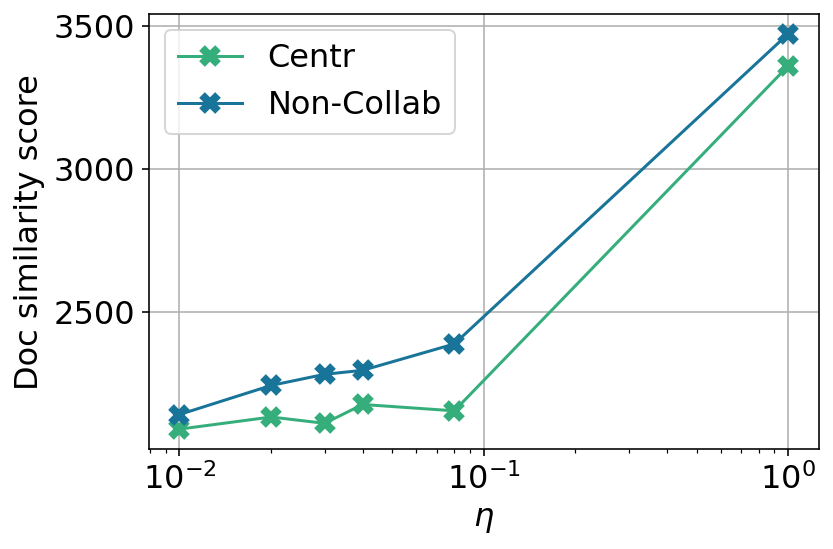

In [34]:
plt.semilogx(eta_list, sim_thetas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.semilogx(eta_list, sim_thetas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
plt.legend(loc="best")

plt.xlabel(r'$\eta$', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()

In [35]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[7.485392896010173, 11.492452169734557, 14.432896169806927, 16.65925228671235, 22.61529915442255, 44.28426786184931]
[6.145248337491847, 10.114971015503738, 13.192069706143172, 15.671478077902393, 22.163250745370902, 44.28426668234745]


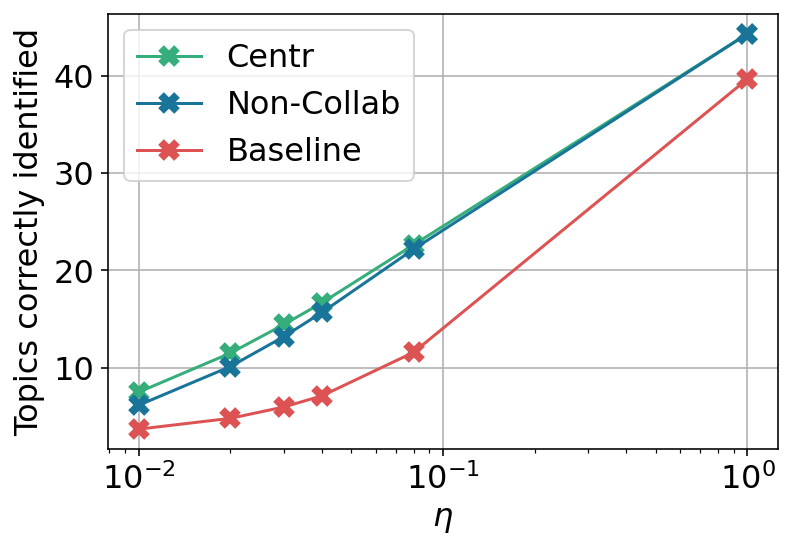

In [36]:
plt.semilogx(eta_list, sim_betas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
plt.semilogx(eta_list, sim_betas_non_colab, label="Non-Collab", marker="x", markersize=8, mew=4, color = "#187498")
plt.semilogx(eta_list, sim_betas_bas, label="Baseline", marker="x", markersize=8, mew=4, color = "#DD5353")

plt.legend(loc="best")

plt.xlabel(r'$\eta$', fontsize=16)
plt.ylabel('Topics correctly identified', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()